In [1]:
!pip install ttach
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install lion_pytorch

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn import preprocessing
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
from tensorboardX import SummaryWriter
import warnings
from lion_pytorch import Lion
warnings.filterwarnings('ignore')
writer = SummaryWriter('runs')

<Axes: >

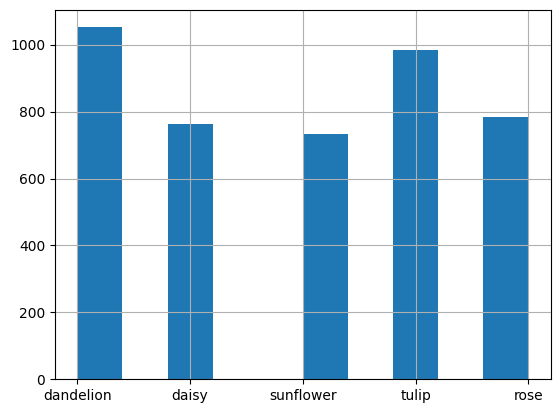

In [4]:
paths = []
labels = []
root_dir = "/kaggle/input/flowers-recognition/flowers"
for flower in os.listdir(root_dir):
    flower_dir = os.path.join(root_dir, flower)
    for img_name in os.listdir(flower_dir):
        paths.append(os.path.join(flower, img_name))
        labels.append(flower)
                
data = pd.DataFrame({"path": paths, "label": labels})
data.label.hist()

In [5]:
le = preprocessing.LabelEncoder()
data.label = le.fit_transform(data.label)

print("Dataset size:", data.shape)
print("Classes:", le.classes_)

Dataset size: (4317, 2)
Classes: ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data.label = le.fit_transform(data.label)

In [7]:
train_data, temp_data = train_test_split(
    data, train_size=0.56, random_state=42, stratify=data['label']
)
val_data, test_data = train_test_split(
    temp_data, test_size=(30/44), random_state=42, stratify=temp_data['label']
)
print("Train size:", train_data.shape)
print("Validation size:", val_data.shape)
print("Test size:", test_data.shape)

Train size: (2417, 2)
Validation size: (604, 2)
Test size: (1296, 2)


In [8]:
class FlowerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, "path"])
        image = Image.open(img_path)
        label = self.df.loc[idx, "label"]
        if self.transform:
            image = self.transform(image)
        return image, label
        
def make_loader(dataset, train_batch_size, validation_split=0.2):
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=train_batch_size, shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False,)
    return train_loader, test_loader

def data_split(data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        data, data["label"], test_size=test_size, stratify = data.iloc[:,1]
    )
    return x_train, x_test, y_train, y_test

In [9]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(5),
    T.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.2),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

In [10]:
x_train, x_test, y_train, y_test = data_split(data, test_size=0.3)

train_dataset = FlowerDataset(x_train, root_dir=root_dir, transform=train_transform)
val_dataset = FlowerDataset(x_train, root_dir=root_dir, transform=test_transform)
test_dataset = FlowerDataset(x_test, root_dir=root_dir, transform=test_transform)

def make_loader(dataset, train_batch_size, validation_split=0.2):
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = make_loader(train_dataset, train_batch_size=32, validation_split=0.4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.dim = dim

    def forward(self, pred, target):
        target = F.one_hot(target, num_classes=pred.size(-1)).float()
        target = (1 - self.smoothing) * target + self.smoothing / pred.size(-1)
        log_pred = F.log_softmax(pred, dim=self.dim)
        loss = nn.KLDivLoss(reduction='batchmean')(log_pred, target)
        return loss

criterion = LabelSmoothingLoss(smoothing=0.12)

In [12]:
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights

def init_model(model, device):
    for param in model.parameters():
        param.requires_grad = False
    if isinstance(model, nn.Module):
        if isinstance(model, models.EfficientNet):
            num_ftrs = model.classifier[1].in_features
        elif isinstance(model, models.ResNet):
            num_ftrs = model.fc.in_features
        else: raise ValueError(f"Unsupported model type: {type(model)}")
        classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 5)
        )
        model.classifier = classifier
        model = model.to(device)
    return model

def train_one_epoch(model, train_loader, val_loader, device, optimizer, criterion):
    model.train()
    train_loss = 0
    all_train_labels = []
    all_train_preds = []
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())
    
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    
    model.eval()
    val_loss = 0
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())
    
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    
    return train_loss, train_acc, val_loss, val_acc

def evaluate_model(model, loader, device, criterion):
    model.eval()
    test_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    test_loss = test_loss / len(loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)
    return test_loss, test_acc, all_labels, all_preds

In [13]:
### Time to experiment


# from rich.console import Console
# from rich.progress import Progress
# from rich.text import Text

# console = Console()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# models_exp = {
#     "EfficientNet_b4": init_model(models.efficientnet_b4(pretrained=True), device),
# }
# models_train = {}
# num_epochs = 20
# best_val_acc = 0

# for model_name, model in models_exp.items():
#     model = init_model(models.efficientnet_b4(pretrained=True), device)
#     optimizers = {
#         "AdamW": optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4),
#         "Lion": Lion(model.parameters(), lr=0.001, weight_decay=1e-4),
#     }
#     schedulers = {
#         "ReduceLROnPlateau": ReduceLROnPlateau(optimizers["AdamW"], mode="min", patience=4, factor=0.5, verbose=True),
#         "CosineAnnealingLR": CosineAnnealingLR(optimizers["AdamW"], T_max=10),
#         "CosineAnnealingWarmRestarts": CosineAnnealingWarmRestarts(optimizers["AdamW"], T_0=5, T_mult=2)
#     }
#     for optimizer_name, optimizer in optimizers.items():
#         for scheduler_name, scheduler in schedulers.items():
#             console.print(f"[bold green]Begin training for model: {model_name} with optimizer: {optimizer_name} and scheduler: {scheduler_name}[/bold green]")
#             with Progress(transient=True) as progress:
#                 task = progress.add_task("[cyan]Training...", total=num_epochs)
#                 for epoch in range(num_epochs):
#                     train_loss, train_acc, val_loss, val_acc = train_one_epoch(model, train_loader, val_loader, device, optimizer, criterion)
#                     scheduler.step(val_loss)
#                     progress.update(task, advance=1)
#                     writer.add_scalar('Train/Loss', train_loss, epoch)
#                     writer.add_scalar('Val/Loss', val_loss, epoch)
#                     writer.add_scalar('Train/Acc', train_acc, epoch)
#                     writer.add_scalar('Val/Acc', val_acc, epoch)
#                     console.print(f"[bold yellow]Epoch {epoch+1}/{num_epochs}:[/bold yellow]")
#                     console.print(f"  [bold]Train Loss[/bold]: {train_loss:.4f}  [bold]Train Acc[/bold]: {train_acc:.4f}")
#                     console.print(f"  [bold]Val Loss[/bold]: {val_loss:.4f}  [bold]Val Acc[/bold]: {val_acc:.4f}")
#                     if val_acc > best_val_acc:
#                         best_val_acc = val_acc
#                         torch.save(model, "./best.pt")
#                         console.print("[bold cyan]Saved best model.[/bold cyan]\n")
#     models_train[f"{model_name}_{optimizer_name}_{scheduler_name}"] = model


### Best Model: EfficientNet_b4 with optimizer: AdamW and CosineAnnealingWarmRestarts with val_acc = 0.9330 and train_acc = 0.9939

In [14]:
# num_epochs = 10
# console = Console()
# for model_name, model in models_train.items():
#     for param in model.parameters():
#         param.requires_grad = True
    
#     optimizers = {
#         "Adam": torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0),
#         "AdamW": optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4),
#         "Lion": Lion(model.parameters(), lr=0.001, weight_decay=1e-4),
#     }
    
#     schedulers = {
#         "ReduceLROnPlateau": ReduceLROnPlateau(optimizers["AdamW"], mode="min", patience=2, factor=0.5, verbose=True),
#         "CosineAnnealingLR": CosineAnnealingLR(optimizers["AdamW"], T_max=10),
#         "CosineAnnealingWarmRestarts": CosineAnnealingWarmRestarts(optimizers["AdamW"], T_0=5, T_mult=2)
#     }
    
#     for optimizer_name, optimizer in optimizers.items():
#         for scheduler_name, scheduler in schedulers.items():
#             console.print(f"[bold green]Begin training for model: {model_name} with optimizer: {optimizer_name} and scheduler: {scheduler_name}[/bold green]")
#             with Progress(transient=True) as progress:
#                 task = progress.add_task("[cyan]Training...", total=num_epochs)
#                 for epoch in range(num_epochs):
#                     train_loss, train_acc, val_loss, val_acc = train_one_epoch(model, train_loader, val_loader, device, optimizer, criterion)
#                     scheduler.step(val_loss)
#                     writer.add_scalar('Train/Loss', train_loss, epoch)
#                     writer.add_scalar('Val/Loss', val_loss, epoch)
#                     writer.add_scalar('Train/Acc', train_acc, epoch)
#                     writer.add_scalar('Val/Acc', val_acc, epoch)
#                     progress.update(task, advance=1)
#                     console.print(f"[bold yellow]Epoch {epoch+1}/{num_epochs}:[/bold yellow]")
#                     console.print(f"  [bold]Train Loss[/bold]: {train_loss:.4f}  [bold]Train Acc[/bold]: {train_acc:.4f}")
#                     console.print(f"  [bold]Val Loss[/bold]: {val_loss:.4f}  [bold]Val Acc[/bold]: {val_acc:.4f}")
#                     if val_acc > best_val_acc:
#                         best_val_acc = val_acc
#                         torch.save(model, "./best.pt")
#                         console.print("[bold cyan]Saved best model.[/bold cyan]\n")

### Best Model: EfficientNet_b4 with optimizer: AdamW and CosineAnnealingWarmRestarts with val_acc = 0.9330 and train_acc = 0.9939

In [15]:
from rich.console import Console
from rich.progress import Progress
from rich.text import Text

console = Console()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_exp = {
    "EfficientNet_b4": init_model(models.efficientnet_b4(pretrained=True), device),
}
num_epochs = 30
best_val_acc = 0

for model_name, model in models_exp.items():
    optimizers = {
        "AdamW": optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4),
    }
    schedulers = {
        "CosineAnnealingWarmRestarts": CosineAnnealingWarmRestarts(optimizers["AdamW"], T_0=5, T_mult=2)
    }
    for optimizer_name, optimizer in optimizers.items():
        for scheduler_name, scheduler in schedulers.items():
            console.print(f"[bold green]Begin training for model: {model_name} with optimizer: {optimizer_name} and scheduler: {scheduler_name}[/bold green]")
            with Progress(transient=True) as progress:
                task = progress.add_task("[cyan]Training...", total=num_epochs)
                for epoch in range(num_epochs):
                    train_loss, train_acc, val_loss, val_acc = train_one_epoch(model, train_loader, val_loader, device, optimizer, criterion)
                    scheduler.step(val_loss)
                    progress.update(task, advance=1)
                    writer.add_scalar('Train/Loss', train_loss, epoch)
                    writer.add_scalar('Val/Loss', val_loss, epoch)
                    writer.add_scalar('Train/Acc', train_acc, epoch)
                    writer.add_scalar('Val/Acc', val_acc, epoch)
                    console.print(f"[bold yellow]Epoch {epoch+1}/{num_epochs}:[/bold yellow]")
                    console.print(f"  [bold]Train Loss[/bold]: {train_loss:.4f}  [bold]Train Acc[/bold]: {train_acc:.4f}")
                    console.print(f"  [bold]Val Loss[/bold]: {val_loss:.4f}  [bold]Val Acc[/bold]: {val_acc:.4f}")
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        torch.save(model, "./best.pt")
                        console.print("[bold cyan]Saved best model.[/bold cyan]")
                    console.print(f"  [bold]Current Best Validation Accuracy[/bold]: {best_val_acc:.4f}")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 203MB/s]


Begin training for model: EfficientNet_b4 with optimizer: AdamW and scheduler: CosineAnnealingWarmRestarts

Output()

Epoch 1/30:

Train Loss: 0.6235  Train Acc: 0.6661

Val Loss: 0.3685  Val Acc: 0.8362

Saved best model.

Current Best Validation Accuracy: 0.8362

Epoch 2/30:

Train Loss: 0.4106  Train Acc: 0.8008

Val Loss: 0.3382  Val Acc: 0.8453

Epoch 3/30:

Train Loss: 0.3778  Train Acc: 0.8262

Val Loss: 0.3259  Val Acc: 0.8519

Epoch 4/30:

Train Loss: 0.3676  Train Acc: 0.8256

Val Loss: 0.3103  Val Acc: 0.8453

Current Best Validation Accuracy: 0.8519

Epoch 5/30:

Train Loss: 0.3470  Train Acc: 0.8400

Val Loss: 0.3014  Val Acc: 0.8553

Epoch 6/30:

Train Loss: 0.3215  Train Acc: 0.8504

Val Loss: 0.2982  Val Acc: 0.8544

Current Best Validation Accuracy: 0.8553

Epoch 7/30:

Train Loss: 0.3285  Train Acc: 0.8493

Val Loss: 0.2890  Val Acc: 0.8553

Current Best Validation Accuracy: 0.8553

Epoch 8/30:

Train Loss: 0.2756  Train Acc: 0.8769

Val Loss: 0.3029  Val Acc: 0.8577

Epoch 9/30:

Train Loss: 0.2911  Train Acc: 0.8681

Val Loss: 0.2785  Val Acc: 0.8718

Saved best model.

Current Best Validation Accuracy: 0.8718

Epoch 10/30:

Train Loss: 0.2702  Train Acc: 0.8819

Val Loss: 0.2729  Val Acc: 0.8602

Current Best Validation Accuracy: 0.8718

Epoch 11/30:

Train Loss: 0.2894  Train Acc: 0.8703

Val Loss: 0.2804  Val Acc: 0.8652

Current Best Validation Accuracy: 0.8718

Epoch 12/30:

Train Loss: 0.2786  Train Acc: 0.8736

Val Loss: 0.2875  Val Acc: 0.8619

Current Best Validation Accuracy: 0.8718

Epoch 13/30:

Train Loss: 0.2627  Train Acc: 0.8852

Val Loss: 0.2844  Val Acc: 0.8561

Current Best Validation Accuracy: 0.8718

Epoch 14/30:

Train Loss: 0.2846  Train Acc: 0.8675

Val Loss: 0.2870  Val Acc: 0.8644

Current Best Validation Accuracy: 0.8718

Epoch 15/30:

Train Loss: 0.2735  Train Acc: 0.8830

Val Loss: 0.2945  Val Acc: 0.8561

Current Best Validation Accuracy: 0.8718

Epoch 16/30:

Train Loss: 0.2660  Train Acc: 0.8791

Val Loss: 0.2689  Val Acc: 0.8825

Epoch 17/30:

Train Loss: 0.2664  Train Acc: 0.8813

Val Loss: 0.2896  Val Acc: 0.8635

Current Best Validation Accuracy: 0.8825

Epoch 18/30:

Train Loss: 0.2561  Train Acc: 0.8841

Val Loss: 0.2642  Val Acc: 0.8718

Current Best Validation Accuracy: 0.8825

Epoch 19/30:

Train Loss: 0.2348  Train Acc: 0.8962

Val Loss: 0.2624  Val Acc: 0.8809

Current Best Validation Accuracy: 0.8825

Epoch 20/30:

Train Loss: 0.2335  Train Acc: 0.8968

Val Loss: 0.2563  Val Acc: 0.8768

Current Best Validation Accuracy: 0.8825

Epoch 21/30:

Train Loss: 0.2329  Train Acc: 0.8940

Val Loss: 0.2778  Val Acc: 0.8619

Current Best Validation Accuracy: 0.8825

Epoch 22/30:

Train Loss: 0.2326  Train Acc: 0.8985

Val Loss: 0.2571  Val Acc: 0.8784

Current Best Validation Accuracy: 0.8825

Epoch 23/30:

Train Loss: 0.2181  Train Acc: 0.9029

Val Loss: 0.2736  Val Acc: 0.8577

Current Best Validation Accuracy: 0.8825

Epoch 24/30:

Train Loss: 0.2175  Train Acc: 0.9073

Val Loss: 0.2556  Val Acc: 0.8776

Current Best Validation Accuracy: 0.8825

Epoch 25/30:

Train Loss: 0.2257  Train Acc: 0.8990

Val Loss: 0.2632  Val Acc: 0.8718

Current Best Validation Accuracy: 0.8825

Epoch 26/30:

Train Loss: 0.2288  Train Acc: 0.8968

Val Loss: 0.2611  Val Acc: 0.8759

Current Best Validation Accuracy: 0.8825

Epoch 27/30:

Train Loss: 0.2283  Train Acc: 0.8935

Val Loss: 0.2719  Val Acc: 0.8701

Current Best Validation Accuracy: 0.8825

Epoch 28/30:

Train Loss: 0.2109  Train Acc: 0.9134

Val Loss: 0.2690  Val Acc: 0.8734

Current Best Validation Accuracy: 0.8825

Epoch 29/30:

Train Loss: 0.2117  Train Acc: 0.9111

Val Loss: 0.2754  Val Acc: 0.8619

Current Best Validation Accuracy: 0.8825

Epoch 30/30:

Train Loss: 0.2125  Train Acc: 0.9100

Val Loss: 0.2635  Val Acc: 0.8743

Current Best Validation Accuracy: 0.8825

Test Loss: 0.2730, Test Accuracy: 0.8603
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       229
           1       0.86      0.91      0.88       316
           2       0.90      0.80      0.85       235
           3       0.83      0.85      0.84       220
           4       0.82      0.88      0.85       296

    accuracy                           0.86      1296
   macro avg       0.86      0.86      0.86      1296
weighted avg       0.86      0.86      0.86      1296



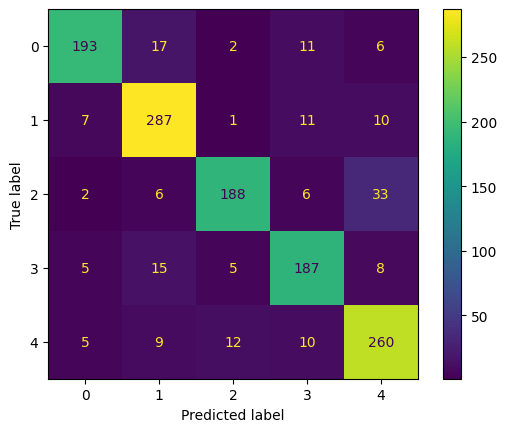

In [16]:
model = torch.load("./best.pt")

test_loss, test_acc, test_labels, test_preds = evaluate_model(model, test_loader, device, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[str(cls) for cls in le.classes_]))

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(cls) for cls in le.classes_])
disp.plot()

In [17]:
num_epochs = 15
console = Console()
for model_name, model in models_exp.items():
    for param in model.parameters():
        param.requires_grad = True
    for optimizer_name, optimizer in optimizers.items():
        for scheduler_name, scheduler in schedulers.items():
            console.print(f"[bold green]Begin training for model: {model_name} with optimizer: {optimizer_name} and scheduler: {scheduler_name}[/bold green]")
            with Progress(transient=True) as progress:
                task = progress.add_task("[cyan]Training...", total=num_epochs)
                for epoch in range(num_epochs):
                    train_loss, train_acc, val_loss, val_acc = train_one_epoch(model, train_loader, val_loader, device, optimizer, criterion)
                    scheduler.step(val_loss)
                    writer.add_scalar('Train/Loss', train_loss, epoch)
                    writer.add_scalar('Val/Loss', val_loss, epoch)
                    writer.add_scalar('Train/Acc', train_acc, epoch)
                    writer.add_scalar('Val/Acc', val_acc, epoch)
                    progress.update(task, advance=1)
                    console.print(f"[bold yellow]Epoch {epoch+1}/{num_epochs}:[/bold yellow]")
                    console.print(f"  [bold]Train Loss[/bold]: {train_loss:.4f}  [bold]Train Acc[/bold]: {train_acc:.4f}")
                    console.print(f"  [bold]Val Loss[/bold]: {val_loss:.4f}  [bold]Val Acc[/bold]: {val_acc:.4f}")
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        torch.save(model, "./best.pt")
                        console.print("[bold cyan]Saved best model.[/bold cyan]")
                    console.print(f"  [bold]Current Best Validation Accuracy[/bold]: {best_val_acc:.4f}")

Begin training for model: EfficientNet_b4 with optimizer: AdamW and scheduler: CosineAnnealingWarmRestarts

Output()

Epoch 1/15:

Train Loss: 0.2477  Train Acc: 0.8885

Val Loss: 0.1990  Val Acc: 0.9148

Epoch 2/15:

Train Loss: 0.1653  Train Acc: 0.9338

Val Loss: 0.1792  Val Acc: 0.9123

Current Best Validation Accuracy: 0.9148

Epoch 3/15:

Train Loss: 0.1307  Train Acc: 0.9553

Val Loss: 0.1793  Val Acc: 0.9074

Current Best Validation Accuracy: 0.9148

Epoch 4/15:

Train Loss: 0.1061  Train Acc: 0.9658

Val Loss: 0.1574  Val Acc: 0.9239

Epoch 5/15:

Train Loss: 0.0825  Train Acc: 0.9735

Val Loss: 0.1549  Val Acc: 0.9272

Saved best model.

Current Best Validation Accuracy: 0.9272

Epoch 6/15:

Train Loss: 0.0670  Train Acc: 0.9829

Val Loss: 0.1529  Val Acc: 0.9272

Current Best Validation Accuracy: 0.9272

Epoch 7/15:

Train Loss: 0.0696  Train Acc: 0.9790

Val Loss: 0.1549  Val Acc: 0.9280

Saved best model.

Current Best Validation Accuracy: 0.9280

Epoch 8/15:

Train Loss: 0.0711  Train Acc: 0.9829

Val Loss: 0.1559  Val Acc: 0.9305

Epoch 9/15:

Train Loss: 0.0666  Train Acc: 0.9807

Val Loss: 0.1593  Val Acc: 0.9206

Current Best Validation Accuracy: 0.9305

Epoch 10/15:

Train Loss: 0.0468  Train Acc: 0.9906

Val Loss: 0.1207  Val Acc: 0.9462

Epoch 11/15:

Train Loss: 0.0583  Train Acc: 0.9845

Val Loss: 0.1438  Val Acc: 0.9322

Current Best Validation Accuracy: 0.9462

Epoch 12/15:

Train Loss: 0.0560  Train Acc: 0.9851

Val Loss: 0.1405  Val Acc: 0.9297

Current Best Validation Accuracy: 0.9462

Epoch 13/15:

Train Loss: 0.0474  Train Acc: 0.9906

Val Loss: 0.1502  Val Acc: 0.9313

Current Best Validation Accuracy: 0.9462

Epoch 14/15:

Train Loss: 0.0448  Train Acc: 0.9890

Val Loss: 0.1338  Val Acc: 0.9355

Current Best Validation Accuracy: 0.9462

Epoch 15/15:

Train Loss: 0.0464  Train Acc: 0.9917

Val Loss: 0.1516  Val Acc: 0.9347

Current Best Validation Accuracy: 0.9462

Test Loss: 0.1316, Test Accuracy: 0.9375
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       229
           1       0.92      0.95      0.94       316
           2       0.96      0.92      0.94       235
           3       0.97      0.91      0.94       220
           4       0.90      0.95      0.92       296

    accuracy                           0.94      1296
   macro avg       0.94      0.94      0.94      1296
weighted avg       0.94      0.94      0.94      1296



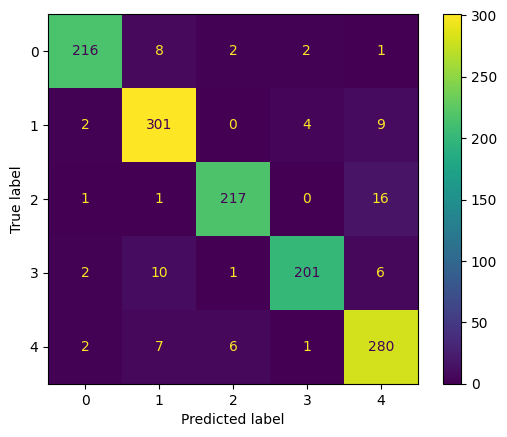

In [18]:
model = torch.load("./best.pt")
test_loss, test_acc, test_labels, test_preds = evaluate_model(model, test_loader, device, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[str(cls) for cls in le.classes_]))
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(cls) for cls in le.classes_])
disp.plot()

TTA Test Loss: 0.1415, TTA Test Accuracy: 0.9329
TTA Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       229
           1       0.92      0.96      0.94       316
           2       0.93      0.94      0.93       235
           3       0.97      0.91      0.94       220
           4       0.93      0.91      0.92       296

    accuracy                           0.93      1296
   macro avg       0.93      0.93      0.93      1296
weighted avg       0.93      0.93      0.93      1296



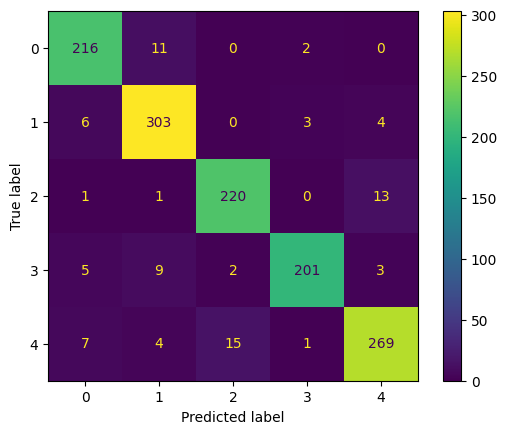

In [19]:
import ttach as tta
from ttach import transforms as tta_transforms

tta_model = torch.load("./best.pt")
tta_model = tta_model.to(device)

tta_transforms = tta.Compose([
    tta.HorizontalFlip(),
    tta.Rotate90(angles=[0, 90, 180, 270]),
    tta.Scale(scales=[1.0, 1.2, 1.5]),
    tta.Multiply(factors=[0.8, 0.9, 1.0, 1.1, 1.2]),
])

tta_model = tta.ClassificationTTAWrapper(tta_model, tta_transforms)
tta_test_loss, tta_test_acc, tta_labels, tta_preds = evaluate_model(tta_model, test_loader, device, criterion)
print(f"TTA Test Loss: {tta_test_loss:.4f}, TTA Test Accuracy: {tta_test_acc:.4f}")
print("TTA Classification Report:")
print(classification_report(tta_labels, tta_preds, target_names=[str(cls) for cls in le.classes_]))
cm = confusion_matrix(tta_labels, tta_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(cls) for cls in le.classes_])
disp.plot()
